In [1]:
import numpy as np
import pandas as pd
import itertools
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
from scipy.stats.mstats import zscore
import matplotlib.gridspec as gridspec
import statsmodels.api as sm
from tqdm import tqdm

# Load data

In [3]:
def bootstrapped(data,n_resamples = 20):
    data = (data,)
    bootstrap_ci = scipy.stats.bootstrap(data, np.mean, confidence_level=0.95,n_resamples=n_resamples,
                         random_state=1, method='percentile')
    return np.abs(bootstrap_ci.confidence_interval[1] - np.mean(data))

In [4]:
def set_fig_(ax , xlabel=0, ylabel=0 , xlog=0, ylog=0, fontsize=16, iflegend=0 , ncol=1, legendloc=2,color = 'k'):
    if xlabel!=0:
        ax.set_xlabel(xlabel,size = fontsize)
    else:
        ax.set_xlabel('')
    if ylabel!=0:
        ax.set_ylabel(ylabel,size = fontsize,color =color)
    else:
        ax.set_ylabel('')
    if ylog:
        ax.set_yscale("log")
    if xlog:
        ax.set_xscale("log")
    if iflegend==1:
        ax.legend(frameon =False,fontsize = 14, loc=legendloc)
    if iflegend==2:
        ax.legend(frameon =False,fontsize = fontsize,ncol=ncol,bbox_to_anchor=(1, 0), loc=3, borderaxespad=0)
    ax.tick_params(axis='x',labelsize=14)
    ax.tick_params(axis='y',labelsize=14,labelcolor =color)
    plt.tick_params(axis='both', which='major', labelsize=16)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines["right"].set_linewidth(2)
    ax.spines["top"].set_linewidth(2)

In [5]:
df = pd.read_csv(r"E:\Data\Patent\KPSS\TextInnovation.csv.zip")
df['KI5'] = np.log(df['fsim5']/df['bsim5'])
for col in ['bsim5', 'fsim1', 'fsim5','fsim10', 'np_b5', 'np_f1', 'np_f5', 'np_f10']:
    del df[col]
df = df[df['filed_year'].isin(range(1980,2018))].reset_index(drop=True)

cd = pd.read_csv(r"E:\Data\Patent\KPSS\citations\Disruption.csv.zip")
cd['CD5'] = (cd['D5']-cd['C5'])/(cd['D5']+cd['C5']+cd['R5'])
df['CD5'] = df['patent_id'].map(cd.set_index('patent_id')['CD5'])

df['CD5_pct'] = df['CD5'].rank() / len(df['CD5'].dropna()) * 100
df['KI5_pct'] = df['KI5'].rank() / len(df['KI5'].dropna()) * 100

df['top10_ki'] = 0
df.loc[df['KI5_pct']>90 , 'top10_ki'] = 1
df['top5_cd'] = 0
df.loc[df['CD5_pct']>90 , 'top5_cd'] = 1

In [6]:
fp = pd.read_csv(r"E:\Data\Patent\Patent\Novelty\Firstpair.csv.zip")
df = df.merge(fp , on = 'patent_id')

In [7]:
fg = pd.read_csv(r"E:\Data\Patent\Patent\Novelty\FirstGroup.csv.zip")
df = df.merge(fg , on = 'patent_id')

In [8]:
HHI = pd.read_csv(r"E:\Data\Patent\Patent\Novelty\patent_hhi.csv.zip")
df = df.merge(HHI , on = 'patent_id')

In [9]:
ref_age = pd.read_csv(r"E:\Data\Patent\Patent\Novelty\patents_RefAge.csv.zip")
df['Ref_age'] = df['patent_id'].map(ref_age.set_index('patent_id')['mean'])

ref_pop = pd.read_csv(r"E:\Data\Patent\Patent\Novelty\patents_RefPop.csv.zip")
df['Ref_pop'] = df['patent_id'].map(ref_pop.set_index('patent_id')['avg_ref_cit5'])

f1 = pd.read_csv(r'E:\Data\Patent\patent\patent.csv.zip',usecols=['patent_id','Reference_Count'])
df['Ref'] = df['patent_id'].map(f1.set_index('patent_id')['Reference_Count'])

C:\Users\nd\AppData\Local\Temp\ipykernel_3436\3397065786.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  ref_age = pd.read_csv(r"E:\Data\Patent\Patent\Novelty\patents_RefAge.csv.zip")


In [10]:
df.columns

Index(['patent_id', 'filed_year', 'issue_year', 'KI5', 'CD5', 'CD5_pct',
       'KI5_pct', 'top10_ki', 'top5_cd', 'first_pair', 'avg_pair_age',
       'first_group', 'avg_group_age', 'HHI', 'HHI2', 'HHI3', 'Ref_age',
       'Ref_pop', 'Ref'],
      dtype='object')

# Novelty

In [10]:
df['HHI3_'] = df['HHI3'].map(lambda x:np.round(x,1))

hhi_d1 = df.groupby('HHI3_')['KI5'].mean().reset_index()
hhi_d2 = df.groupby('HHI3_')['CD5'].mean().reset_index()

hhi_ci1 = df.dropna(subset=['HHI3_','KI5']).groupby('HHI3_')['KI5'].apply(bootstrapped).reset_index()
hhi_ci2 = df.dropna(subset=['HHI3_','CD5']).groupby('HHI3_')['CD5'].apply(bootstrapped).reset_index()

def draw_hhi():
    color='#922B21'
    plt.plot(hhi_d1['HHI3_'].values , hhi_d1['KI5'].values , color=color , lw=2 )
    plt.plot(hhi_d1['HHI3_'].values , hhi_d1['KI5'].values+hhi_ci1['KI5'].values , color=color, ls='--' , lw=.5)
    plt.plot(hhi_d1['HHI3_'].values , hhi_d1['KI5'].values-hhi_ci1['KI5'].values , color=color, ls='--' , lw=.5)
    set_fig_(ax, 'HHI score', '$KI_5$', color = color)
    ax_ = ax.twinx()
    color='#138D75'
    plt.plot(hhi_d2['HHI3_'].values , hhi_d2['CD5'].values , color=color , lw=2 )
    plt.plot(hhi_d2['HHI3_'].values , hhi_d2['CD5'].values+hhi_ci2['CD5'].values , color=color, ls='--' , lw=.5)
    plt.plot(hhi_d2['HHI3_'].values , hhi_d2['CD5'].values-hhi_ci2['CD5'].values , color=color, ls='--' , lw=.5)
    set_fig_(ax_, 'HHI score', '$CD_5$', color = color)

In [11]:
df['type'] = 0
df.loc[df['first_pair']==1 , 'type'] = 1
df.loc[df['first_group']==1 , 'type'] = 2

fg_d1 = df.groupby('type')['KI5'].mean().reset_index()
fg_d2 = df.groupby('type')['CD5'].mean().reset_index()
fg_ci1 = df.dropna(subset=['type','KI5']).groupby('type')['KI5'].apply(bootstrapped).reset_index()
fg_ci2 = df.dropna(subset=['type','CD5']).groupby('type')['CD5'].apply(bootstrapped).reset_index()

def draw_fg():
    color='#922B21'
    plt.plot(fg_d1['type'].values , fg_d1['KI5'].values , color=color , lw=2 )
    plt.plot(fg_d1['type'].values , fg_d1['KI5'].values+fg_ci1['KI5'].values , color=color, ls='--' , lw=.5)
    plt.plot(fg_d1['type'].values , fg_d1['KI5'].values-fg_ci1['KI5'].values , color=color, ls='--' , lw=.5)
    plt.xticks([0,1,2],['Others','1st CPC\npair','1st CPC\ngroup'])
    set_fig_(ax, 0, '$KI_5$', color = color)
    ax_ = ax.twinx()
    color='#138D75'
    plt.plot(fg_d2['type'].values , fg_d2['CD5'].values , color=color , lw=2 )
    plt.plot(fg_d2['type'].values , fg_d2['CD5'].values+fg_ci2['CD5'].values , color=color, ls='--' , lw=.5)
    plt.plot(fg_d2['type'].values , fg_d2['CD5'].values-fg_ci2['CD5'].values , color=color, ls='--' , lw=.5)
    set_fig_(ax_, 0, '$CD_5$', color = color)

In [12]:
df['avg_group_age_'] = df['avg_group_age'].apply(lambda x:np.ceil(x))
df.loc[df['avg_group_age_']>5 , 'avg_group_age_'] = 5

age_d1 = df.groupby('avg_group_age_')['KI5'].mean().reset_index()
age_d2 = df.groupby('avg_group_age_')['CD5'].mean().reset_index()
age_ci1 = df.groupby('avg_group_age_')['KI5'].apply(bootstrapped).reset_index()
age_ci2 = df.groupby('avg_group_age_')['CD5'].apply(bootstrapped).reset_index()

In [13]:
a1 = age_d1['KI5'].values[0]
a2 = age_d1['KI5'].values[1]
age_d1.iloc[0,1] = a2
age_d1.iloc[1,1] = a1

In [14]:
def draw_age():
    color='#922B21'
    plt.plot(age_d1['avg_group_age_'].values , age_d1['KI5'].values , color=color , lw=2 )
    plt.plot(age_d1['avg_group_age_'].values , age_d1['KI5'].values+age_ci1['KI5'].values , color=color, ls='--' , lw=.5)
    plt.plot(age_d1['avg_group_age_'].values , age_d1['KI5'].values-age_ci1['KI5'].values , color=color, ls='--' , lw=.5)
    plt.xticks([0,1,2,3,4,5])
    set_fig_(ax, 'Average CPC\ngroup age', '$KI_5$', color = color)
    ax_ = ax.twinx()
    color='#138D75'
    plt.plot(age_d2['avg_group_age_'].values , age_d2['CD5'].values , color=color , lw=2 )
    plt.plot(age_d2['avg_group_age_'].values , age_d2['CD5'].values+age_ci2['CD5'].values , color=color, ls='--' , lw=.5)
    plt.plot(age_d2['avg_group_age_'].values , age_d2['CD5'].values-age_ci2['CD5'].values , color=color, ls='--' , lw=.5)
    set_fig_(ax_, 'Average CPC\ngroup age', '$CD_5$', color = color)

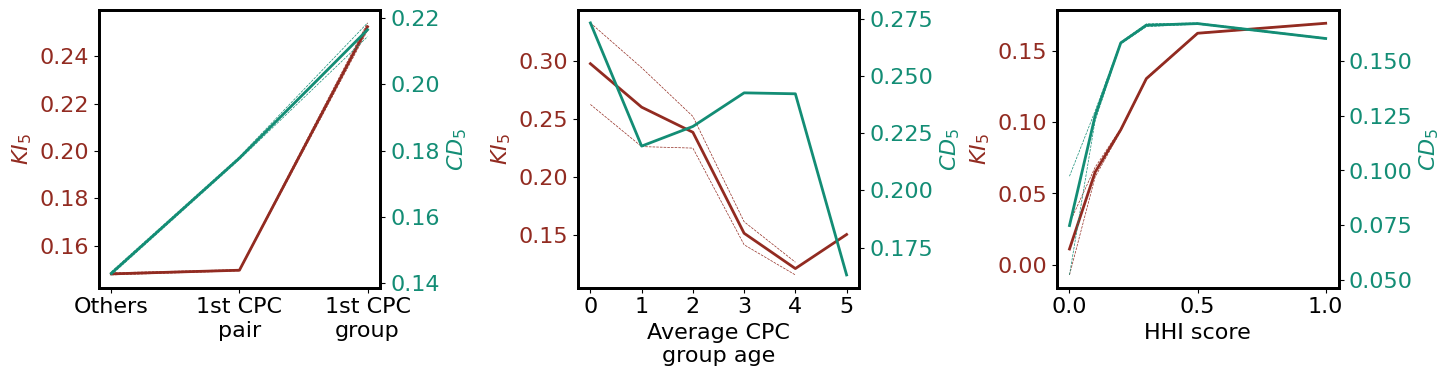

In [17]:
fig = plt.figure(figsize=(16,9))
gs = gridspec.GridSpec(2, 3, figure=fig)
gs.update(wspace=0.7,hspace=0.5)

ax = fig.add_subplot(gs[0])
draw_fg()

ax = fig.add_subplot(gs[1])
draw_age()

ax = fig.add_subplot(gs[2])
draw_hhi()
plt.savefig(savepath + "with_novelty.svg",bbox_inches = 'tight')

# Ref

In [23]:
df.loc[df['Ref']>15,'Ref'] = 15

Ref_d1 = df.groupby('Ref')['KI5'].mean().reset_index()
Ref_d2 = df.groupby('Ref')['CD5'].mean().reset_index()

Ref_ci1 = df.dropna(subset=['Ref','KI5']).groupby('Ref')['KI5'].apply(bootstrapped).reset_index()
Ref_ci2 = df.dropna(subset=['Ref','CD5']).groupby('Ref')['CD5'].apply(bootstrapped).reset_index()

def draw_Ref():
    color='#922B21'
    plt.plot(Ref_d1['Ref'].values , Ref_d1['KI5'].values , color=color , lw=2 )
    plt.plot(Ref_d1['Ref'].values , Ref_d1['KI5'].values+Ref_ci1['KI5'].values , color=color, ls='--' , lw=.5)
    plt.plot(Ref_d1['Ref'].values , Ref_d1['KI5'].values-Ref_ci1['KI5'].values , color=color, ls='--' , lw=.5)
    set_fig_(ax, '#Reference', '$KI_5$', color = color)
    ax_ = ax.twinx()
    color='#138D75'
    plt.plot(Ref_d2['Ref'].values[1:] , Ref_d2['CD5'].values[1:] , color=color , lw=2 )
    plt.plot(Ref_d2['Ref'].values[1:] , Ref_d2['CD5'].values[1:]+Ref_ci2['CD5'].values[1:] , color=color, ls='--' , lw=.5)
    plt.plot(Ref_d2['Ref'].values[1:] , Ref_d2['CD5'].values[1:]-Ref_ci2['CD5'].values[1:] , color=color, ls='--' , lw=.5)
    set_fig_(ax_, '#Reference', '$CD_5$', color = color)

In [10]:
df.loc[df['Ref_age']>20,'Ref_age'] = 20
df.loc[df['Ref_age']<0,'Ref_age'] = 0
df['Ref_age'] = df['Ref_age'].apply(lambda x:np.round(x,0))

Ref_age_d1 = df.groupby('Ref_age')['KI5'].mean().reset_index()
Ref_age_d2 = df.groupby('Ref_age')['CD5'].mean().reset_index()

Ref_age_ci1 = df.dropna(subset=['Ref_age','KI5']).groupby('Ref_age')['KI5'].apply(bootstrapped).reset_index()
Ref_age_ci2 = df.dropna(subset=['Ref_age','CD5']).groupby('Ref_age')['CD5'].apply(bootstrapped).reset_index()

def draw_Ref_age():
    color='#922B21'
    plt.plot(Ref_age_d1['Ref_age'].values[3:] , Ref_age_d1['KI5'].values[3:] , color=color , lw=2 )
    plt.plot(Ref_age_d1['Ref_age'].values[3:] , Ref_age_d1['KI5'].values[3:]+Ref_age_ci1['KI5'].values[3:] , color=color, ls='--' , lw=.5)
    plt.plot(Ref_age_d1['Ref_age'].values[3:] , Ref_age_d1['KI5'].values[3:]-Ref_age_ci1['KI5'].values[3:] , color=color, ls='--' , lw=.5)
    set_fig_(ax, 'Avg ref age', '$KI_5$', color = color)
    ax_ = ax.twinx()
    color='#138D75'
    plt.plot(Ref_age_d2['Ref_age'].values[3:] , Ref_age_d2['CD5'].values[3:] , color=color , lw=2 )
    plt.plot(Ref_age_d2['Ref_age'].values[3:] , Ref_age_d2['CD5'].values[3:]+Ref_age_ci2['CD5'].values[3:] , color=color, ls='--' , lw=.5)
    plt.plot(Ref_age_d2['Ref_age'].values[3:] , Ref_age_d2['CD5'].values[3:]-Ref_age_ci2['CD5'].values[3:] , color=color, ls='--' , lw=.5)
    set_fig_(ax_, 'Avg ref age', '$CD_5$', color = color)

In [11]:
df.loc[df['Ref_pop']>20,'Ref_pop'] = 20
df['Ref_pop'] = df['Ref_pop'].apply(lambda x:np.round(x,0))

Ref_pop_d1 = df.groupby('Ref_pop')['KI5'].mean().reset_index()
Ref_pop_d2 = df.groupby('Ref_pop')['CD5'].mean().reset_index()

Ref_pop_ci1 = df.dropna(subset=['Ref_pop','KI5']).groupby('Ref_pop')['KI5'].apply(bootstrapped).reset_index()
Ref_pop_ci2 = df.dropna(subset=['Ref_pop','CD5']).groupby('Ref_pop')['CD5'].apply(bootstrapped).reset_index()

def draw_Ref_pop():
    color='#922B21'
    plt.plot(Ref_pop_d1['Ref_pop'].values , Ref_pop_d1['KI5'].values , color=color , lw=2 )
    plt.plot(Ref_pop_d1['Ref_pop'].values , Ref_pop_d1['KI5'].values+Ref_pop_ci1['KI5'].values , color=color, ls='--' , lw=.5)
    plt.plot(Ref_pop_d1['Ref_pop'].values , Ref_pop_d1['KI5'].values-Ref_pop_ci1['KI5'].values , color=color, ls='--' , lw=.5)
    set_fig_(ax, 'Ref popularity', '$KI_5$', color = color)
    ax_ = ax.twinx()
    color='#138D75'
    plt.plot(Ref_pop_d2['Ref_pop'].values[1:] , Ref_pop_d2['CD5'].values[1:] , color=color , lw=2 )
    plt.plot(Ref_pop_d2['Ref_pop'].values[1:] , Ref_pop_d2['CD5'].values[1:]+Ref_pop_ci2['CD5'].values[1:] , color=color, ls='--' , lw=.5)
    plt.plot(Ref_pop_d2['Ref_pop'].values[1:] , Ref_pop_d2['CD5'].values[1:]-Ref_pop_ci2['CD5'].values[1:] , color=color, ls='--' , lw=.5)
    set_fig_(ax_, 'Ref popularity', '$CD_5$', color = color)

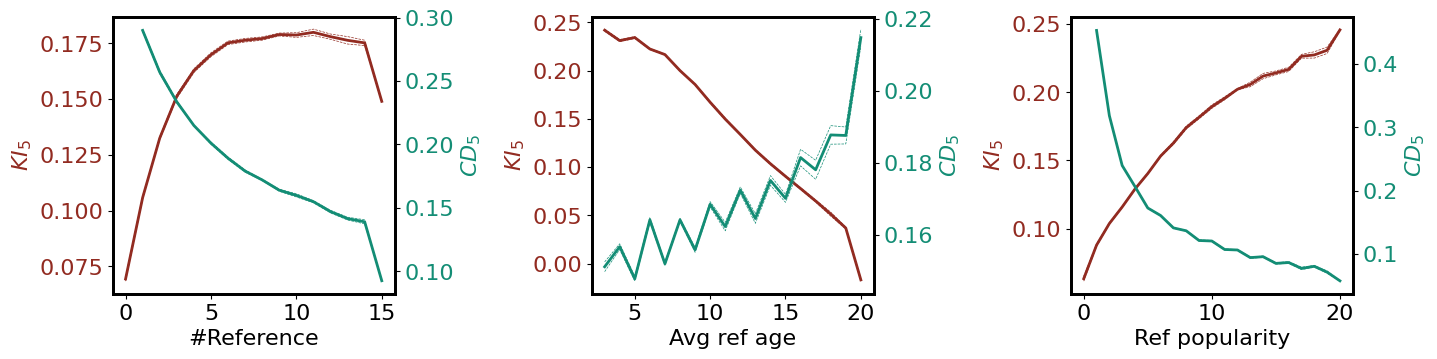

In [29]:
fig = plt.figure(figsize=(16,9))
gs = gridspec.GridSpec(2, 3, figure=fig)
gs.update(wspace=0.7,hspace=0.5)

ax = fig.add_subplot(gs[0])
draw_Ref()

ax = fig.add_subplot(gs[1])
draw_Ref_age()

ax = fig.add_subplot(gs[2])
draw_Ref_pop()
plt.savefig(savepath + "with_ref.svg",bbox_inches = 'tight')

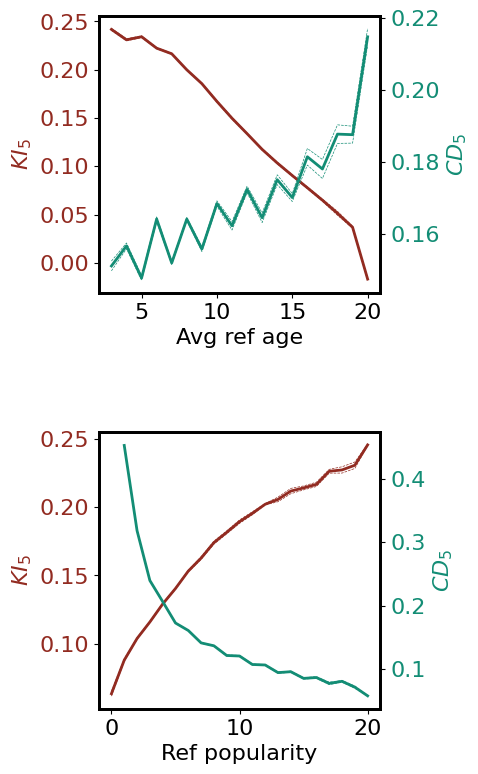

In [13]:
fig = plt.figure(figsize=(16,9))
gs = gridspec.GridSpec(2, 3, figure=fig)
gs.update(wspace=0.7,hspace=0.5)

ax = fig.add_subplot(gs[0])
draw_Ref_age()

ax = fig.add_subplot(gs[3])
draw_Ref_pop()
plt.savefig(r"F:\A J YANG PAPER\2ndRound\RP Text based and citation based disruption in science\Figs\Explanations\with_ref.svg",bbox_inches = 'tight')